<a href="https://colab.research.google.com/github/Ranjani94/Advanced_Deep_Learning/blob/master/Assignment_1_Part_2/SSL_credit_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'advanced_DL'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFNx6tRLppWk9IZ2iffX1WB6P_rKQVpCXq838dAJR6QIXQxgPsMp6A
Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:

# Load the data
current_path = os.getcwd()
file = os.path.sep.join(['', '/gdrive/My Drive/advanced_DL/datasets', 'credit_card_data', 'credit.csv'])
data = pd.read_csv(current_path + file)

dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

# Scale data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

# Split into train and test
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [14]:
dataX.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.875569,-0.272499,1.663939,0.912529,-0.290615,0.295121,0.150634,0.178994,0.398020,0.037563,-0.667131,-1.347069,-0.968644,-0.160849,1.371151,-0.435956,0.401329,0.251564,0.464223,0.333227,-0.011617,0.664810,-0.180954,0.115092,0.038888,-0.480964,0.352200,-0.037017,0.462734
1,1.055422,0.025850,-0.705891,0.159812,0.085583,-0.162804,-0.230542,0.163926,-0.282853,-0.222083,1.501881,1.256920,0.689851,0.051381,0.445818,0.741049,-0.056118,-0.020220,-0.225337,-0.259265,-0.359887,-0.864465,0.394763,-0.544776,0.131209,0.203302,-0.069657,0.101331,-0.354937
2,-0.874469,-1.388130,0.900814,0.104472,-0.446328,1.419960,0.811298,0.344101,-1.667475,0.155262,0.511516,-0.288964,0.945487,0.023268,2.346573,-3.484147,1.679665,0.060349,-2.879436,0.838964,0.435419,1.488828,2.591810,-1.111627,-1.051296,-0.372314,-0.206890,-0.186663,1.737351
3,-0.577758,-0.371480,0.920597,-0.901635,0.019166,0.954850,0.148252,0.487909,-1.527136,-0.109245,-0.341315,-0.115455,0.710757,-0.131378,-0.962241,-1.178259,-0.862929,2.772493,-1.588511,-0.516147,-0.162687,0.210014,-0.398033,-1.900491,1.278807,-0.552243,0.142560,0.282047,0.317375
4,-0.723026,0.564207,0.676326,0.123293,-0.355659,-0.012937,0.573639,-0.230209,0.897177,0.704665,-0.938962,0.441486,1.649622,-1.185885,-0.065891,-0.412082,-0.229344,0.168418,0.965291,0.623709,0.003282,1.533211,-0.254316,0.235684,-0.760618,1.020916,0.606318,0.876379,0.019590


In [15]:
dataY.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [16]:
dataX.dropna(axis='columns')


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.875569,-0.272499,1.663939,0.912529,-0.290615,0.295121,0.150634,0.178994,0.398020,0.037563,-0.667131,-1.347069,-0.968644,-0.160849,1.371151,-0.435956,0.401329,0.251564,0.464223,0.333227,-0.011617,0.664810,-0.180954,0.115092,0.038888,-0.480964,0.352200,-0.037017,0.462734
1,1.055422,0.025850,-0.705891,0.159812,0.085583,-0.162804,-0.230542,0.163926,-0.282853,-0.222083,1.501881,1.256920,0.689851,0.051381,0.445818,0.741049,-0.056118,-0.020220,-0.225337,-0.259265,-0.359887,-0.864465,0.394763,-0.544776,0.131209,0.203302,-0.069657,0.101331,-0.354937
2,-0.874469,-1.388130,0.900814,0.104472,-0.446328,1.419960,0.811298,0.344101,-1.667475,0.155262,0.511516,-0.288964,0.945487,0.023268,2.346573,-3.484147,1.679665,0.060349,-2.879436,0.838964,0.435419,1.488828,2.591810,-1.111627,-1.051296,-0.372314,-0.206890,-0.186663,1.737351
3,-0.577758,-0.371480,0.920597,-0.901635,0.019166,0.954850,0.148252,0.487909,-1.527136,-0.109245,-0.341315,-0.115455,0.710757,-0.131378,-0.962241,-1.178259,-0.862929,2.772493,-1.588511,-0.516147,-0.162687,0.210014,-0.398033,-1.900491,1.278807,-0.552243,0.142560,0.282047,0.317375
4,-0.723026,0.564207,0.676326,0.123293,-0.355659,-0.012937,0.573639,-0.230209,0.897177,0.704665,-0.938962,0.441486,1.649622,-1.185885,-0.065891,-0.412082,-0.229344,0.168418,0.965291,0.623709,0.003282,1.533211,-0.254316,0.235684,-0.760618,1.020916,0.606318,0.876379,0.019590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321,-0.480608,0.631975,0.154759,0.345060,0.298943,0.152727,1.114815,-0.079243,-0.138208,-0.311515,-1.053429,0.171080,0.614042,-0.102447,-0.665088,-0.808342,0.192387,-0.769814,-0.114324,-0.590482,0.044700,0.668841,-0.158495,-0.398854,-0.693538,-1.020806,-0.536740,0.676098,0.053759
1322,-0.337334,0.703501,1.656165,-0.024739,1.013510,0.325874,1.624057,-1.107313,0.155628,1.378972,1.096680,0.140437,1.193426,-1.148009,0.676945,0.045994,-1.873090,0.917115,1.365481,0.916257,-0.600509,-0.252817,-1.112580,-0.834810,0.027797,-1.446829,-3.044817,-3.789553,-0.342082
1323,1.007516,-0.196576,-0.127763,0.961936,-0.606719,-0.341642,-0.427185,0.207897,0.473766,0.032445,0.695987,0.495537,-1.495092,0.632201,-1.413772,-0.111343,-0.038226,0.458994,0.185664,-0.556437,0.006157,0.415532,-0.142898,0.855024,1.257175,-0.716508,0.033670,0.089380,-0.314535
1324,0.881376,-0.667493,-0.596074,0.257718,-0.774209,-0.819509,-0.018776,-0.084571,0.656183,-0.324025,-0.814917,-0.797029,-1.244153,0.658411,0.245824,0.129310,0.103935,-0.435399,0.200519,0.106068,-0.265515,-1.103275,-0.034963,0.652481,0.276876,0.871089,-0.281217,0.178162,0.509369


In [18]:
dataY.dropna()


0       0
1       0
2       0
3       0
4       0
       ..
1321    0
1322    0
1323    0
1324    0
1325    0
Name: Class, Length: 1326, dtype: int64

In [19]:
# Drop 95% of the labels from the training set
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [21]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [22]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [23]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [24]:

params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}


In [25]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0
[3]	valid_0's binary_logloss: 0
[4]	valid_0's binary_logloss: 0
[5]	valid_0's binary_logloss: 0
[6]	valid_0's binary_logloss: 0
[7]	valid_0's binary_logloss: 0
[8]	valid_0's binary_logloss: 0
[9]	valid_0's binary_logloss: 0
[10]	valid_0's binary_logloss: 0
[11]	valid_0's binary_logloss: 0
[12]	valid_0's binary_logloss: 0
[13]	valid_0's binary_logloss: 0
[14]	valid_0's binary_logloss: 0
[15]	valid_0's binary_logloss: 0
[16]	valid_0's binary_logloss: 0
[17]	valid_0's binary_logloss: 0
[18]	valid_0's binary_logloss: 0
[19]	valid_0's binary_logloss: 0
[20]	valid_0's binary_logloss: 0
[21]	valid_0's binary_logloss: 0
[22]	valid_0's binary_logloss: 0
[23]	valid_0's binary_logloss: 0
[24]	valid_0's binary_logloss: 0
[25]	valid_0's binary_logloss: 0
[26]	valid_0's binary_logloss: 0
[27]	valid_0's binary_logloss: 0
[28]	valid_0's binary_logloss: 0
[29]	valid_0's binary_

ValueError: ignored

In [27]:

preds, average_precision = plotResults(y_train, predictionsBasedOnKFolds.loc[:,'prediction'], True)

ValueError: ignored

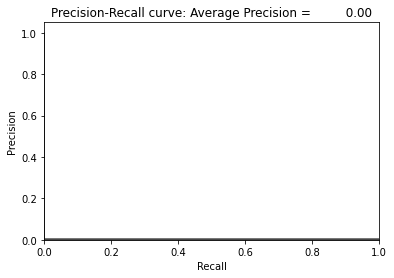

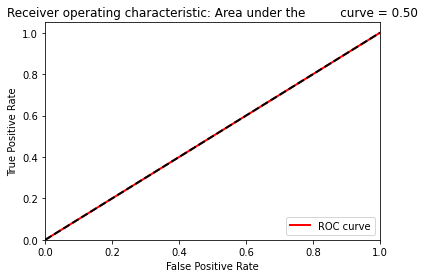

In [28]:
predictions = pd.Series(data=gbm.predict(X_test, \
                    num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [29]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

IndexError: ignored

In [30]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), \
                        index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', \
                               ascending=False,inplace=True)
featuresImportance

,featImportance
V1,NaN
V2,NaN
V3,NaN
V4,NaN
V5,NaN
V6,NaN
V7,NaN
V8,NaN
V9,NaN
V10,NaN
